In [3]:
# Loading library
import os
os.sys.path.append("../")
from scripts.etl_pipeline import *

In [4]:
# Create a Spark Session
spark = (
    SparkSession.builder.appName("ETL Pipeline")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "2g")
    .getOrCreate()
)

24/09/10 06:35:47 WARN Utils: Your hostname, Alistairs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.20.10.4 instead (on interface en0)
24/09/10 06:35:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/10 06:35:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/10 06:35:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Extract

As we can't use `urlretrieve` to get the data from Canvas, please download it to your local machine and move it `data/tables`. Then run the code below to unzip the files

In [5]:
# Assign data path
raw_path = "../data"

# Unzip files (Only run once)
"""
for file in os.listdir(f"{raw_path}/tables"):
    if file == ".gitkeep":
        continue
    with zipfile.ZipFile(f"{raw_path}/tables/{file}", "r") as zip_ref:
        zip_ref.extractall(f"{raw_path}/")
    os.remove(f"{raw_path}/tables/{file}")
"""

'\nfor file in os.listdir(f"{raw_path}/tables"):\n    if file == ".gitkeep":\n        continue\n    with zipfile.ZipFile(f"{raw_path}/tables/{file}", "r") as zip_ref:\n        zip_ref.extractall(f"{raw_path}/")\n    os.remove(f"{raw_path}/tables/{file}")\n'

# Transform

The system use `user_id` as a key for identifying customer in transactions record and fraud probability tables. However, they also have a key-value map of `user_id` and `consumer_id`. We will use `consumer_id` as the only ID for customer. Thus, we will map `user_id` from each table to `consumer_id` and drop the former.


In [6]:
# Load consumer user details -> a key:value map for user_id to consumer_id
consumer_user_map = spark.read.parquet(f"{raw_path}/tables/consumer_user_details.parquet")
consumer_user_map.limit(5) # Preview

user_id,consumer_id
1,1195503
2,179208
3,1194530
4,154128
5,712975


In [7]:
# Load consumer fraud rate dataset
consumer_fraud_rate = spark.read.csv(f"{raw_path}/tables/consumer_fraud_probability.csv", header=True, inferSchema=True)
consumer_fraud_rate.show(5)
get_dataset_count(consumer_fraud_rate)

# Replace all user_id with unique consumer_id
consumer_fraud_rate = replace_id(consumer_user_map, consumer_fraud_rate)
consumer_fraud_rate.show(5)

# Check to make sure no rows were lost on the inner join
get_dataset_count(consumer_fraud_rate)

+-------+--------------+-----------------+
|user_id|order_datetime|fraud_probability|
+-------+--------------+-----------------+
|   6228|    2021-12-19| 97.6298077657765|
|  21419|    2021-12-10|99.24738020302328|
|   5606|    2021-10-17|84.05825045251777|
|   3101|    2021-04-17|91.42192091901347|
|  22239|    2021-10-19|94.70342477508035|
+-------+--------------+-----------------+
only showing top 5 rows

The dataset count is  34864
+--------------+------------------+-----------+
|order_datetime| fraud_probability|consumer_id|
+--------------+------------------+-----------+
|    2022-02-20| 9.805431136520959|    1195503|
|    2021-08-30| 9.599513915425788|     179208|
|    2021-09-25|10.069850934775245|     179208|
|    2021-11-03| 8.300636455314633|    1194530|
|    2021-10-09| 9.633302411090419|     154128|
+--------------+------------------+-----------+
only showing top 5 rows

The dataset count is  34864


In [8]:
# Load all the transaction data 
transaction_p1 = spark.read.parquet(f"{raw_path}/tables/transactions_20210228_20210827_snapshot")
transaction_p2 = spark.read.parquet(f"{raw_path}/tables/transactions_20210828_20220227_snapshot")
transaction_p3 = spark.read.parquet(f"{raw_path}/tables/transactions_20220228_20220828_snapshot")

# Combine the datasets
transaction_records = reduce(DataFrame.unionAll, [transaction_p1, transaction_p2, transaction_p3])
# transaction_records.show(5)
get_dataset_count(transaction_records)

# Replace user_id with consumer_id after combining
transaction_records = replace_id(consumer_user_map, transaction_records)
transaction_records.show(5)

# Check to make sure no rows were lost on the inner join
get_dataset_count(transaction_records)

The dataset count is  14195505
+------------+------------------+--------------------+--------------+-----------+
|merchant_abn|      dollar_value|            order_id|order_datetime|consumer_id|
+------------+------------------+--------------------+--------------+-----------+
| 62191208634|63.255848959735246|949a63c8-29f7-4ab...|    2021-08-20|     651338|
| 15549624934| 130.3505283105634|6a84c3cf-612a-457...|    2021-08-20|     179208|
| 64403598239|120.15860593212783|b10dcc33-e53f-425...|    2021-08-20|     467663|
| 60956456424| 136.6785200286976|0f09c5a5-784e-447...|    2021-08-20|    1194530|
| 94493496784| 72.96316578355305|f6c78c1a-4600-4c5...|    2021-08-20|     467663|
+------------+------------------+--------------------+--------------+-----------+
only showing top 5 rows



The dataset count is  14195505


## Cleaning

Now that replacing `user_id` to `consumer_id` is done, load all other data and clean them. First, let's have a look at the merchant data on fraud probability.

In [9]:
# Load merchant fraud rate dataset
merchant_fraud_rate = spark.read.csv(f"{raw_path}/tables/merchant_fraud_probability.csv", header=True, inferSchema=True)
merchant_fraud_rate.show(5)
get_dataset_count(merchant_fraud_rate)

+------------+--------------+------------------+
|merchant_abn|order_datetime| fraud_probability|
+------------+--------------+------------------+
| 19492220327|    2021-11-28|44.403658647495355|
| 31334588839|    2021-10-02| 42.75530083865367|
| 19492220327|    2021-12-22|38.867790051131095|
| 82999039227|    2021-12-19|  94.1347004808891|
| 90918180829|    2021-09-02| 43.32551731714902|
+------------+--------------+------------------+
only showing top 5 rows

The dataset count is  114


Cleaning `tbl_merchants.parquet`. The feature `tags` is a string that represents either a tuple or a list, containing 3 elements:
* Items that are being sold
* Revenue levels
* Commission rate

Each elements either a list, a tuple, or a combination of both (e.g starts with `[` and ends with `)` and vice versa). These inconsistencies are mostly due to human errors. Thus, we need to take into account these consistent when splitting the values of the feature `tags` into separate columns

In [10]:
# Load merchant's info
merchant_info = spark.read.parquet(f"{raw_path}/tables/tbl_merchants.parquet")
merchant_info.show(5, truncate=False)

# Clean the data
merchant_info = clean_merchant_details(merchant_info)
merchant_info.show(5, truncate=False)

+------------------------------------+-----------------------------------------------------------------------------------------------------------------+------------+
|name                                |tags                                                                                                             |merchant_abn|
+------------------------------------+-----------------------------------------------------------------------------------------------------------------+------------+
|Felis Limited                       |((furniture, home furnishings and equipment shops, and manufacturers, except appliances), (e), (take rate: 0.18))|10023283211 |
|Arcu Ac Orci Corporation            |([cable, satellite, and otHer pay television and radio services], [b], [take rate: 4.22])                        |10142254217 |
|Nunc Sed Company                    |([jewelry, watch, clock, and silverware shops], [b], [take rate: 4.40])                                          |10165489824 |
|Ult

The data on consumer's basic information is a single column that contains the consumer's name, address, state, postcode, gender, and their unqiue consumer ID, each separated by "`|`". Thus, we will need to split these into individual columns. Based on the `README.md` for the data, we will only keep the consumer's name, state, postcode, gender, and consumer ID as the addresses are fake.

In [11]:
# Load consumer info's
consumer_info = spark.read.csv(f"{raw_path}/tables/tbl_consumer.csv", header=True, inferSchema=True)
consumer_info.show(5, truncate=False)

# Clean the data
consumer_info = clean_consumer_details(consumer_info)
consumer_info.limit(5)

+---------------------------------------------------------------------+
|name|address|state|postcode|gender|consumer_id                       |
+---------------------------------------------------------------------+
|Yolanda Williams|413 Haney Gardens Apt. 742|WA|6935|Female|1195503   |
|Mary Smith|3764 Amber Oval|NSW|2782|Female|179208                    |
|Jill Jones MD|40693 Henry Greens|NT|862|Female|1194530               |
|Lindsay Jimenez|00653 Davenport Crossroad|NSW|2780|Female|154128     |
|Rebecca Blanchard|9271 Michael Manors Suite 651|WA|6355|Female|712975|
+---------------------------------------------------------------------+
only showing top 5 rows

Before: 
The dataset count is  499999
After: 
The dataset count is  499999


name,consumer_id,gender,state,postcode
Yolanda Williams,1195503,Female,WA,6935
Mary Smith,179208,Female,NSW,2782
Jill Jones MD,1194530,Female,NT,862
Lindsay Jimenez,154128,Female,NSW,2780
Rebecca Blanchard,712975,Female,WA,6355


We will also need to ensure that the datetime of all dataset with such column is within the specified range (labeled on the name of the intial downloaded file)

In [12]:
transaction_records = ensure_datetime_range(transaction_records, "2021-02-28", "2022-08-28")

Starting entries: 14195505 
Final entries: 12561377
Net change (%): 11.51 


In [13]:
merchant_fraud_rate = ensure_datetime_range(merchant_fraud_rate, "2021-02-08", "2022-08-28")

Starting entries: 114 
Final entries: 114
Net change (%): 0.0 


In [14]:
consumer_fraud_rate = ensure_datetime_range(consumer_fraud_rate, "2021-02-08", "2022-08-28")

Starting entries: 34864 
Final entries: 34864
Net change (%): 0.0 


Next,  we check for any existing null values across all dataset.

In [15]:
# Check for Missing values
calculate_missing_values(consumer_fraud_rate)
calculate_missing_values(merchant_fraud_rate)
calculate_missing_values(consumer_info)
calculate_missing_values(merchant_info)
calculate_missing_values(transaction_records)

+----------------------------+-------------------------------+-------------------------+
|order_datetime_missing_count|fraud_probability_missing_count|consumer_id_missing_count|
+----------------------------+-------------------------------+-------------------------+
|                           0|                              0|                        0|
+----------------------------+-------------------------------+-------------------------+

+--------------------------+----------------------------+-------------------------------+
|merchant_abn_missing_count|order_datetime_missing_count|fraud_probability_missing_count|
+--------------------------+----------------------------+-------------------------------+
|                         0|                           0|                              0|
+--------------------------+----------------------------+-------------------------------+



+------------------+-------------------------+--------------------+-------------------+----------------------+
|name_missing_count|consumer_id_missing_count|gender_missing_count|state_missing_count|postcode_missing_count|
+------------------+-------------------------+--------------------+-------------------+----------------------+
|                 0|                        0|                   0|                  0|                     0|
+------------------+-------------------------+--------------------+-------------------+----------------------+

+------------------+--------------------------+----------------------+---------------------------+-----------------------+
|name_missing_count|merchant_abn_missing_count|category_missing_count|revenue_level_missing_count|take_rate_missing_count|
+------------------+--------------------------+----------------------+---------------------------+-----------------------+
|                 0|                         0|                     0|     

+--------------------------+--------------------------+----------------------+----------------------------+-------------------------+
|merchant_abn_missing_count|dollar_value_missing_count|order_id_missing_count|order_datetime_missing_count|consumer_id_missing_count|
+--------------------------+--------------------------+----------------------+----------------------------+-------------------------+
|                         0|                         0|                     0|                           0|                        0|
+--------------------------+--------------------------+----------------------+----------------------------+-------------------------+



# Load

We now export the curated into the `data/curated` directory for analysis and modelling.

In [16]:
landing_directory = "../data/curated"

In [17]:
consumer_fraud_rate.write.parquet(f"{landing_directory}/consumer_fraud_prob.parquet")
merchant_fraud_rate.write.parquet(f"{landing_directory}/merchant_fraud_prob")
transaction_records.write.parquet(f"{landing_directory}/transactions.parquet")
merchant_info.write.parquet(f"{landing_directory}/merchant_info.parquet")
consumer_info.write.parquet(f"{landing_directory}/consumer_info.parquet")

AnalysisException: [PATH_ALREADY_EXISTS] Path file:/Users/alistaircheahwernhao/Documents/GitHub/MAST30034_Python/project-2-group-buy-now-pay-later-industry-project-9/data/curated/consumer_fraud_prob.parquet already exists. Set mode as "overwrite" to overwrite the existing path.

In [ ]:
# Summary Statistics - This block should be move to preliminary analysis notebook
print(f"Summary statistic for consumer's fraud probability")
consumer_fraud_rate.select(F.col("fraud_probability")).describe().show()

print(f"Summary statistics for merchant's fraud probability")
merchant_fraud_rate.select(F.col("fraud_probability")).describe().show()

print(f"Summary statistics for dollar value of transaction records")
transaction_records.select(F.col("dollar_value")).describe().show()

Summary statistic for consumer's fraud probability


+-------+-----------------+
|summary|fraud_probability|
+-------+-----------------+
|  count|            34864|
|   mean|15.12009064415455|
| stddev| 9.94608484957805|
|    min|8.287143531552802|
|    max|99.24738020302328|
+-------+-----------------+

Summary statistics for merchant's fraud probability
+-------+------------------+
|summary| fraud_probability|
+-------+------------------+
|  count|               114|
|   mean|40.419334695018094|
| stddev|17.187744795432526|
|    min| 18.21089142894488|
|    max|  94.1347004808891|
+-------+------------------+

Summary statistics for dollar value of transaction records


+-------+--------------------+
|summary|        dollar_value|
+-------+--------------------+
|  count|            12561377|
|   mean|    166.339820365545|
| stddev|   520.3624254515679|
|    min|9.756658099412162E-8|
|    max|  105193.88578925544|
+-------+--------------------+



In this section, we begin exploratory data analysis to gain a better understanding of the data and our variables

In [ ]:
from pyspark.sql import functions as F

# Revenue analysis
# Explore for each ABN, their total revenue, average order value and total number of orders
merchant_performance = transaction_records.groupBy("merchant_abn").agg(
    F.sum("dollar_value").alias("total_revenue"),
    F.avg("dollar_value").alias("average_order_value"),
    F.count("dollar_value").alias("total_orders")
)

# Rank merchants by total revenue in descending order
merchant_performance = merchant_performance.orderBy(F.col("total_revenue").desc())
merchant_performance.show(10)

get_dataset_count(merchant_performance)
calculate_missing_values(merchant_performance)

+------------+-----------------+-------------------+------------+
|merchant_abn|    total_revenue|average_order_value|total_orders|
+------------+-----------------+-------------------+------------+
| 39649557865|8712769.051186668|  449.1581117221707|       19398|
| 27093785141|8695204.207713189| 377.16683472339673|       23054|
| 96680767841|8679874.166938104| 315.16191013173466|       27541|
| 79827781481|8657277.096810076| 2036.5271928511117|        4251|
| 31334588839|8635672.313515192|  6368.489906722118|        1356|
| 32709545238|8600526.478637582|  751.2689097342402|       11448|
| 82368304209|8559519.374213614| 1865.6319473002645|        4588|
| 50315283629|8513551.597928654| 322.37311514743664|       26409|
| 90568944804|8510417.447779246|  898.9561051842448|        9467|
| 38700038932|8482176.655705513| 1337.6717640286254|        6341|
+------------+-----------------+-------------------+------------+
only showing top 10 rows



The dataset count is  4422


+--------------------------+---------------------------+---------------------------------+--------------------------+
|merchant_abn_missing_count|total_revenue_missing_count|average_order_value_missing_count|total_orders_missing_count|
+--------------------------+---------------------------+---------------------------------+--------------------------+
|                         0|                          0|                                0|                         0|
+--------------------------+---------------------------+---------------------------------+--------------------------+



In [ ]:
from pyspark.sql.functions import avg

merchant_avg_fraud_prob = merchant_fraud_rate.groupBy("merchant_abn").agg(avg("fraud_probability").alias("merchant_avg_fraud_prob"))

merchant_avg_fraud_prob.show()

calculate_missing_values(merchant_avg_fraud_prob)

+------------+-----------------------+
|merchant_abn|merchant_avg_fraud_prob|
+------------+-----------------------+
| 99989036621|      18.21089142894488|
| 90568944804|      30.72298492113958|
| 29674997261|      44.43787807900268|
| 27093785141|      28.88064813052203|
| 19492220327|     31.958306675667547|
| 76968105359|      68.27843632543912|
| 97884414539|      89.79919971536573|
| 82999039227|       94.1347004808891|
| 83199298021|      31.93490297074105|
| 93292821052|      66.58725735032715|
| 43083074133|      48.66890735193894|
| 15157368385|       64.2774131928303|
| 76767266140|     29.539733207182703|
| 96680767841|     29.555244690425017|
| 35909341340|      29.13305311007307|
| 72058040180|      33.71875978884334|
| 19010030815|     51.033927919712056|
| 39649557865|     28.690204286050616|
| 48534649627|      28.56793296472796|
| 85482742429|      70.88131110541714|
+------------+-----------------------+
only showing top 20 rows

+--------------------------+----------

In [ ]:
# Risk Analysis
# Combine revenue analysis with fraud probabilities
merchant_performance_risk = merchant_performance.join(merchant_avg_fraud_prob, on="merchant_abn", how="left")

# Rank merchants by fraud probability in descending order
merchant_performance_risk = merchant_performance_risk.orderBy(F.col("merchant_avg_fraud_prob").desc())
merchant_performance_risk.show(10)

get_dataset_count(merchant_performance_risk)
calculate_missing_values(merchant_performance_risk)

+------------+------------------+-------------------+------------+-----------------------+
|merchant_abn|     total_revenue|average_order_value|total_orders|merchant_avg_fraud_prob|
+------------+------------------+-------------------+------------+-----------------------+
| 82999039227|1265863.7468289626| 16439.788919856655|          77|       94.1347004808891|
| 35575706403|   756768.16345307| 11295.047215717463|          67|      91.09606847149965|
| 97884414539|  623707.133355778| 11137.627381353177|          56|      89.79919971536573|
| 14530561097| 1819182.993382527| 11025.351475045618|         165|      80.80054474543395|
| 23686790459| 673775.4359598871|  17730.93252526019|          38|       79.4543441508535|
| 18737319630| 39719.82955985059|  201.6235003038101|         197|      72.73069736562613|
| 85482742429|34194.427896739355|  71.53646003501957|         478|      70.88131110541714|
| 78080443264| 19336.11299420864| 20.247238737391246|         955|       69.0953172336121|

The dataset count is  4422


+--------------------------+---------------------------+---------------------------------+--------------------------+-------------------------------------+
|merchant_abn_missing_count|total_revenue_missing_count|average_order_value_missing_count|total_orders_missing_count|merchant_avg_fraud_prob_missing_count|
+--------------------------+---------------------------+---------------------------------+--------------------------+-------------------------------------+
|                         0|                          0|                                0|                         0|                                 4361|
+--------------------------+---------------------------+---------------------------------+--------------------------+-------------------------------------+



In [ ]:
# Profitability analysis
# Combine previous merchant_performance_risk with merchants_info to get take_rate and revenue_level
merchant_profitability = merchant_performance_risk.join(merchant_info, on="merchant_abn", how="inner")

# Calculate net revenue
merchant_profitability = merchant_profitability.withColumn(
    "net_revenue", F.col("total_revenue") * F.col("take_rate")/100
)

# Rank merchants by profitability in descending order
merchant_profitability.orderBy(F.col("net_revenue").desc()).show(10)


# Rank merchants by profitability in ascending order
merchant_profitability.orderBy(F.col("net_revenue").asc()).show(10)

get_dataset_count(merchant_profitability)
calculate_missing_values(merchant_profitability)

+------------+-----------------+-------------------+------------+-----------------------+--------------------+--------------------+-------------+---------+------------------+
|merchant_abn|    total_revenue|average_order_value|total_orders|merchant_avg_fraud_prob|                name|            category|revenue_level|take_rate|       net_revenue|
+------------+-----------------+-------------------+------------+-----------------------+--------------------+--------------------+-------------+---------+------------------+
| 79827781481|8657277.096810076| 2036.5271928511117|        4251|        29.735159306496|     Amet Risus Inc.|furniture, home f...|            a|     6.82| 590426.2980024472|
| 48534649627|8316735.671846781| 141.71825290699124|       58685|      28.56793296472796|Dignissim Maecena...|opticians, optica...|            a|     6.64| 552231.2486106262|
| 32361057556|8339994.520798449| 109.94943536575283|       75853|                   NULL|Orci In Consequat...|gift, card, nov

+------------+------------------+-------------------+------------+-----------------------+--------------------+--------------------+-------------+---------+------------------+
|merchant_abn|     total_revenue|average_order_value|total_orders|merchant_avg_fraud_prob|                name|            category|revenue_level|take_rate|       net_revenue|
+------------+------------------+-------------------+------------+-----------------------+--------------------+--------------------+-------------+---------+------------------+
| 55622580330| 9882.349660396516| 380.09037155371215|          26|                   NULL|           Lacus LLP|books, periodical...|            e|      0.1| 9.882349660396518|
| 25019506172| 21967.78175906219|  708.6381212600706|          31|                   NULL|      Proin Vel Inc.|stationery, offic...|            e|     0.16|35.148450814499505|
| 57079678065| 20034.94391058681|  33.95753205184205|         590|                   NULL|Hendrerit Donec L...|digital g

The dataset count is  4026


+--------------------------+---------------------------+---------------------------------+--------------------------+-------------------------------------+------------------+----------------------+---------------------------+-----------------------+-------------------------+
|merchant_abn_missing_count|total_revenue_missing_count|average_order_value_missing_count|total_orders_missing_count|merchant_avg_fraud_prob_missing_count|name_missing_count|category_missing_count|revenue_level_missing_count|take_rate_missing_count|net_revenue_missing_count|
+--------------------------+---------------------------+---------------------------------+--------------------------+-------------------------------------+------------------+----------------------+---------------------------+-----------------------+-------------------------+
|                         0|                          0|                                0|                         0|                                 3978|                 

In [18]:
# Rename fraud_probability in the merchant fraud dataset to 'merchant_fraud_probability'
merchant_fraud_rate = merchant_fraud_rate.withColumnRenamed("fraud_probability", "merchant_fraud_probability")

# Rename fraud_probability in the consumer fraud dataset to 'consumer_fraud_probability'
consumer_fraud_rate = consumer_fraud_rate.withColumnRenamed("fraud_probability", "consumer_fraud_probability")

# Join transaction_records with consumer fraud data
transaction_records_with_consumer_fraud = transaction_records.join(
    consumer_fraud_rate, 
    on=["consumer_id", "order_datetime"], 
    how="left"
)

get_dataset_count(transaction_records_with_consumer_fraud)
calculate_missing_values(transaction_records_with_consumer_fraud)

# Join transaction records with merchant fraud data
transaction_records_with_fraud = transaction_records_with_consumer_fraud.join(
    merchant_fraud_rate, 
    on=["merchant_abn", "order_datetime"], 
    how="left"
)

get_dataset_count(transaction_records_with_fraud)
calculate_missing_values(transaction_records_with_fraud)

# Join transaction records with merchant info
transaction_records_final = transaction_records_with_fraud.join(
    merchant_info, 
    on="merchant_abn", 
    how="inner"
)

get_dataset_count(transaction_records_final)
calculate_missing_values(transaction_records_final)

# Revenue analysis
merchant_performance = transaction_records_final.groupBy("merchant_abn").agg(
    F.sum("dollar_value").alias("total_revenue"),
    F.avg("dollar_value").alias("average_order_value"),
    F.count("dollar_value").alias("total_orders")
)

# Rank merchants by total revenue in descending order
merchant_performance = merchant_performance.orderBy(F.col("total_revenue").desc())
merchant_performance.show(10)

# Risk analysis
merchant_performance_risk = transaction_records_final.groupBy("merchant_abn").agg(
    F.avg("merchant_fraud_probability").alias("merchant_avg_fraud_prob"),
    F.avg("consumer_fraud_probability").alias("consumer_avg_fraud_prob"),
    F.sum("dollar_value").alias("total_revenue"),
    F.avg("dollar_value").alias("average_order_value"),
    F.count("dollar_value").alias("total_orders")
)

# Rank merchants by fraud probability in descending order
merchant_performance_risk = merchant_performance_risk.orderBy(F.col("merchant_avg_fraud_prob").desc())
merchant_performance_risk.show(10)

# Profitability analysis
# Calculate net revenue at the transaction level before aggregation
transaction_records_final = transaction_records_final.withColumn(
    "net_revenue", F.col("dollar_value") * F.col("take_rate")/100
)

# Aggregate net_revenue at the merchant level
merchant_profitability = transaction_records_final.groupBy("merchant_abn").agg(
    F.sum("net_revenue").alias("total_net_revenue"),
    F.sum("dollar_value").alias("total_revenue"),
    F.avg("dollar_value").alias("average_order_value"),
    F.count("dollar_value").alias("total_orders"),
    F.avg("merchant_fraud_probability").alias("merchant_avg_fraud_prob"),
    F.avg("consumer_fraud_probability").alias("consumer_avg_fraud_prob")
)

# Rank merchants by profitability in descending order
merchant_profitability.orderBy(F.col("total_net_revenue").desc()).show(10)



The dataset count is  12561589


+-------------------------+----------------------------+--------------------------+--------------------------+----------------------+----------------------------------------+
|consumer_id_missing_count|order_datetime_missing_count|merchant_abn_missing_count|dollar_value_missing_count|order_id_missing_count|consumer_fraud_probability_missing_count|
+-------------------------+----------------------------+--------------------------+--------------------------+----------------------+----------------------------------------+
|                        0|                           0|                         0|                         0|                     0|                                12481029|
+-------------------------+----------------------------+--------------------------+--------------------------+----------------------+----------------------------------------+



The dataset count is  12561589


+--------------------------+----------------------------+-------------------------+--------------------------+----------------------+----------------------------------------+----------------------------------------+
|merchant_abn_missing_count|order_datetime_missing_count|consumer_id_missing_count|dollar_value_missing_count|order_id_missing_count|consumer_fraud_probability_missing_count|merchant_fraud_probability_missing_count|
+--------------------------+----------------------------+-------------------------+--------------------------+----------------------+----------------------------------------+----------------------------------------+
|                         0|                           0|                        0|                         0|                     0|                                12481029|                                12557495|
+--------------------------+----------------------------+-------------------------+--------------------------+----------------------+---

The dataset count is  12047496


+--------------------------+----------------------------+-------------------------+--------------------------+----------------------+----------------------------------------+----------------------------------------+------------------+----------------------+---------------------------+-----------------------+
|merchant_abn_missing_count|order_datetime_missing_count|consumer_id_missing_count|dollar_value_missing_count|order_id_missing_count|consumer_fraud_probability_missing_count|merchant_fraud_probability_missing_count|name_missing_count|category_missing_count|revenue_level_missing_count|take_rate_missing_count|
+--------------------------+----------------------------+-------------------------+--------------------------+----------------------+----------------------------------------+----------------------------------------+------------------+----------------------+---------------------------+-----------------------+
|                         0|                           0|             

+------------+-----------------+-------------------+------------+
|merchant_abn|    total_revenue|average_order_value|total_orders|
+------------+-----------------+-------------------+------------+
| 39649557865|8713454.729181942|  449.1471509887599|       19400|
| 31334588839|  8710106.7140746|  6413.922469863476|        1358|
| 27093785141|8695204.207713189| 377.16683472339673|       23054|
| 96680767841|8679874.166938104| 315.16191013173466|       27541|
| 79827781481|8657277.096810076| 2036.5271928511117|        4251|
| 32709545238|8600648.766611943|  751.2139721034101|       11449|
| 82368304209|8559519.374213614| 1865.6319473002645|        4588|
| 50315283629|8513752.395678472|   322.368511763668|       26410|
| 90568944804|8510417.447779246|  898.9561051842448|        9467|
| 38700038932|8482176.655705513| 1337.6717640286254|        6341|
+------------+-----------------+-------------------+------------+
only showing top 10 rows



+------------+-----------------------+-----------------------+------------------+-------------------+------------+
|merchant_abn|merchant_avg_fraud_prob|consumer_avg_fraud_prob|     total_revenue|average_order_value|total_orders|
+------------+-----------------------+-----------------------+------------------+-------------------+------------+
| 35575706403|      91.09606847149965|      34.77680586570184| 806977.6688917433| 11867.318660172696|          68|
| 97884414539|      89.79919971536573|      32.40204688123495| 668322.1558769114| 11724.950103103709|          57|
| 14530561097|      80.80054474543395|      31.83820084048247| 1900373.358533844| 11379.481188825412|         167|
| 18737319630|      72.73069736562613|      9.716308521768319| 39719.82955985059|  201.6235003038101|         197|
| 85482742429|      70.88131110541714|     13.662992056430278|34194.427896739355|  71.53646003501957|         478|
| 78080443264|      69.09531723361212|     12.295498809402012| 19336.11299420864

+------------+------------------+-----------------+-------------------+------------+-----------------------+-----------------------+
|merchant_abn| total_net_revenue|    total_revenue|average_order_value|total_orders|merchant_avg_fraud_prob|consumer_avg_fraud_prob|
+------------+------------------+-----------------+-------------------+------------+-----------------------+-----------------------+
| 79827781481| 590426.2980024472|8657277.096810076| 2036.5271928511117|        4251|     29.694380203418124|     12.773830702266268|
| 48534649627| 552231.2486106264|8316735.671846781| 141.71825290699124|       58685|     28.576898179225296|     14.902087132634945|
| 32361057556| 551286.8853157675|8340194.936698451| 109.94917852084174|       75855|                   NULL|     15.816853351282546|
| 86578477987| 542906.0687302679| 8443329.21820013|  34.98505938982655|      241341|                   NULL|     15.121133124846919|
| 38700038932| 535225.3469750176|8482176.655705513| 1337.671764028625

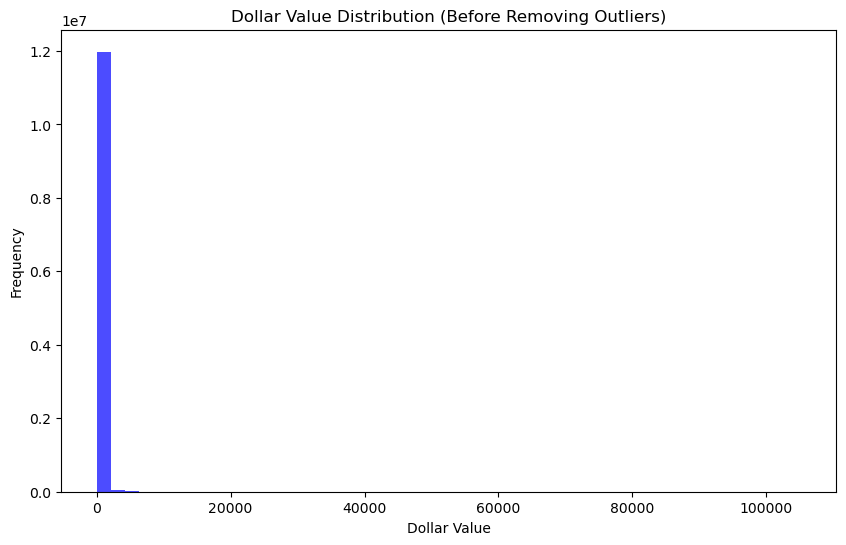

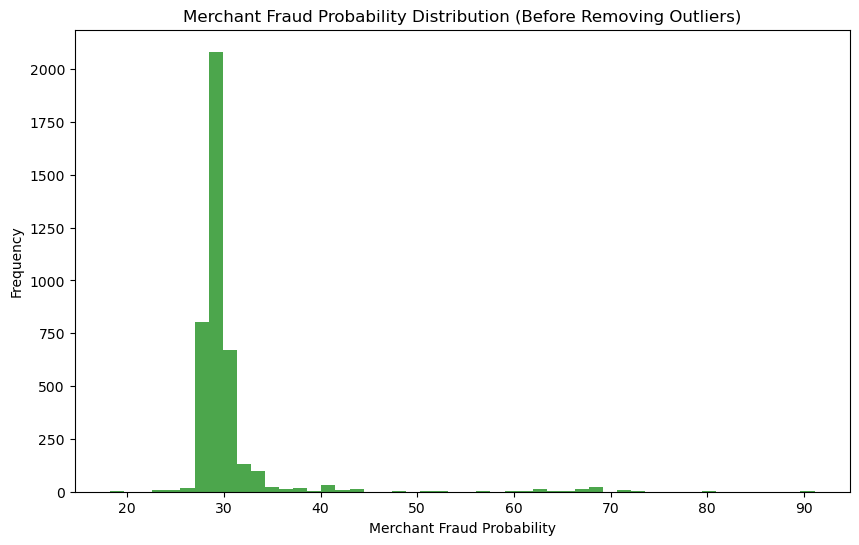

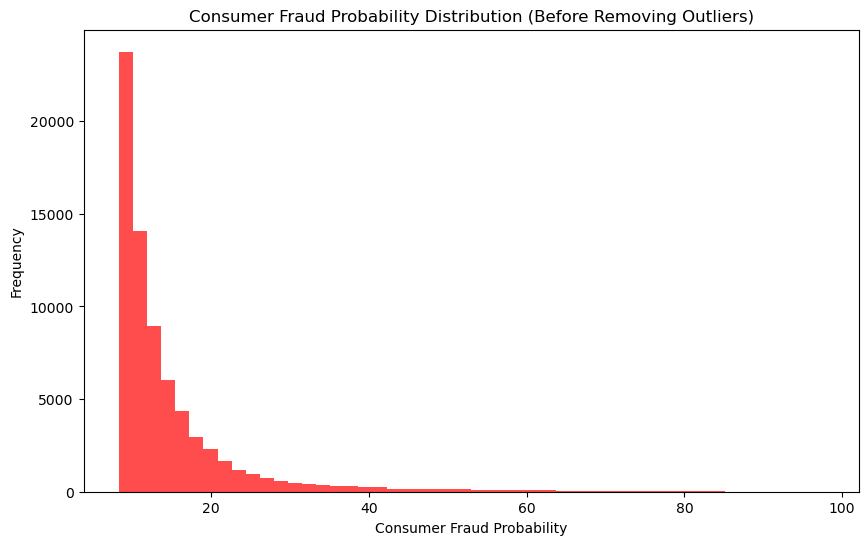

In [19]:
import matplotlib.pyplot as plt

# Convert columns to Pandas for plotting
df_pandas = transaction_records_final.select("dollar_value", "merchant_fraud_probability", "consumer_fraud_probability").toPandas()

# Plot the distribution for dollar_value
plt.figure(figsize=(10, 6))
plt.hist(df_pandas['dollar_value'], bins=50, color='blue', alpha=0.7)
plt.title("Dollar Value Distribution (Before Removing Outliers)")
plt.xlabel("Dollar Value")
plt.ylabel("Frequency")
plt.show()

# Plot the distribution for fraud_probability (merchant)
plt.figure(figsize=(10, 6))
plt.hist(df_pandas['merchant_fraud_probability'], bins=50, color='green', alpha=0.7)
plt.title("Merchant Fraud Probability Distribution (Before Removing Outliers)")
plt.xlabel("Merchant Fraud Probability")
plt.ylabel("Frequency")
plt.show()

# Plot the distribution for fraud_probability (consumer)
plt.figure(figsize=(10, 6))
plt.hist(df_pandas['consumer_fraud_probability'], bins=50, color='red', alpha=0.7)
plt.title("Consumer Fraud Probability Distribution (Before Removing Outliers)")
plt.xlabel("Consumer Fraud Probability")
plt.ylabel("Frequency")
plt.show()


Make analysis on what's the average take rate for each revenue level -> how much money is the BNPL firm make from each revenue level (for example using the total revenue * average take rate) ----> Incorrect description?

In [ ]:
merchant_info.groupBy(F.col("revenue_level")).agg(F.avg(F.col("take_rate"))) # average commission rate of each revenue level

revenue_level,avg(take_rate)
e,0.3147169811320755
d,0.9912244897959185
c,2.2512039045553167
b,4.094056254626199
a,6.232297128589269


In [ ]:
net_revenue_level = merchant_profitability.groupBy('revenue_level').sum('net_revenue') #sum up the net_revenue of BNPL firm for each level
net_revenue_level
#Data shows that make the most net_revenue from small 

revenue_level,sum(net_revenue)
e,70477.14753451252
d,371231.6335187635
c,1.0148181653801005E7
b,3.167370164609193E7
a,5.409203241463862E7


In [ ]:
# Count the occurrences of each revenue level
merchant_profitability.groupBy('revenue_level').count()

revenue_level,count
e,53
d,98
c,922
b,1351
a,1602


In [ ]:
# Count the number of merchants with a fraud probability
fraudulent_merchants_count = merchant_profitability.filter(col("merchant_avg_fraud_prob").isNotNull()).select("merchant_abn").distinct().count()

fraudulent_merchants_count

48

In [ ]:
# # Compute the average fraud probability for each revenue level
average_fraud_by_revenue_level = merchant_profitability.groupBy(F.col("revenue_level")).agg(F.avg(F.col("merchant_avg_fraud_prob")).alias("merchant_avg_fraud_prob"))

# Show the results
average_fraud_by_revenue_level.show()

+-------------+-----------------------+
|revenue_level|merchant_avg_fraud_prob|
+-------------+-----------------------+
|            e|       69.0953172336121|
|            d|      63.37734364737917|
|            c|     47.598333195887776|
|            b|      43.88868549450772|
|            a|       44.5865773709124|
+-------------+-----------------------+



In [ ]:
# Compute the total number of orders for each revenue level
total_orders_by_revenue_level = merchant_profitability.groupBy(F.col("revenue_level")) \
    .agg(F.sum(F.col("total_orders")).alias("total_orders"))

# Show the results
total_orders_by_revenue_level.show()

joined_df = net_revenue_level.join(
    total_orders_by_revenue_level,
    on="revenue_level",
    how="inner"
)
joined_df = joined_df.withColumn("total_orders", F.col("total_orders").cast(DoubleType()))

# Compute the average order value
average_order_value = joined_df.withColumn(
    "avg_order_value",
    F.col("sum(net_revenue)")/ F.col("total_orders")
)

average_order_value


+-------------+------------+
|revenue_level|total_orders|
+-------------+------------+
|            e|      120108|
|            d|      136838|
|            c|     3324800|
|            b|     3921368|
|            a|     6111561|
+-------------+------------+



revenue_level,sum(net_revenue),total_orders,avg_order_value
e,70477.14753451252,120108.0,0.5867814594740777
d,371231.6335187635,136838.0,2.7129279404753324
c,1.0148181653801005E7,3324800.0,3.052268302995971
b,3.167370164609193E7,3921368.0,8.077207149671219
a,5.409203241463862E7,6111561.0,8.850771908296199
